In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from core.util.io import read_csv
from itertools import product
import math

## Utility functions
Utility functions to aid in plotting a weekly average. 

In [78]:
def avg_hourly_consumption(data: pd.DataFrame, column_name: str) -> np.array:
    """Get the average hourly consumption."""
    hour_sum = np.zeros(168)
    hour_count = 6 * 24 - 1  # The dataset starts on saturday 00:00
    non_nan_counter = np.zeros(168)
    for index, row in data.iterrows():
        if not math.isnan(row[column_name]):
            hour_sum[hour_count] += row[column_name]
            non_nan_counter[hour_count] += 1
        if hour_count == 167:
            hour_count = 0
        else:
            hour_count += 1
    return get_avg_weekly(hour_sum, non_nan_counter)


def get_avg_weekly(hour_sum: np.array, non_nan: np.array) -> np.array:
    """Get the average for each hour."""
    return hour_sum / non_nan

In [79]:
# List of weekdays and hours
weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
hours = [f"{hour:02}:00" for hour in range(24)]
# Generate all combinations of weekdays and hours
weekdays_hours = [f"{day} {hour}" for day, hour in product(weekdays, hours)]

## Quick Data Analysis
Reads the caltech data that has been timezone adjusted and is not yet normalized.

Prints the average consumption of the dataset, to compare it to the activity level of the Trefor parks.

Checks for streaks of zeros.

In [89]:
caltech = read_csv("processed/caltech_ev_sessions.csv")

total_zeros = 0
highest_zero_streak = 0
zero_streak_counter = 0
for rows in caltech.iterrows():
    if rows[1]["Consumption"] == 0:
        total_zeros += 1
        zero_streak_counter += 1
    else:
        if zero_streak_counter > highest_zero_streak:
            highest_zero_streak = zero_streak_counter
        zero_streak_counter = 0
print(f"Amount of zeros: {total_zeros}\n")
print(f"Highest zero streak: {highest_zero_streak}\n")
print(caltech.info())
print(caltech["Consumption"].describe())

Amount of zeros: 822

Highest zero streak: 46

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8737 entries, 0 to 8736
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Dato         8737 non-null   object 
 1   Time         8737 non-null   object 
 2   Hour_x       8737 non-null   float64
 3   Hour_y       8737 non-null   float64
 4   Day_x        8737 non-null   float64
 5   Day_y        8737 non-null   float64
 6   Month_x      8737 non-null   float64
 7   Month_y      8737 non-null   float64
 8   Consumption  8737 non-null   float64
dtypes: float64(7), object(2)
memory usage: 614.4+ KB
None
count    8737.000000
mean       10.816246
std        12.355316
min         0.000000
25%         1.566752
50%         5.354695
75%        17.010679
max        61.778797
Name: Consumption, dtype: float64


Plots the a weekly average on an hourly basis

<Figure size 1000x600 with 0 Axes>

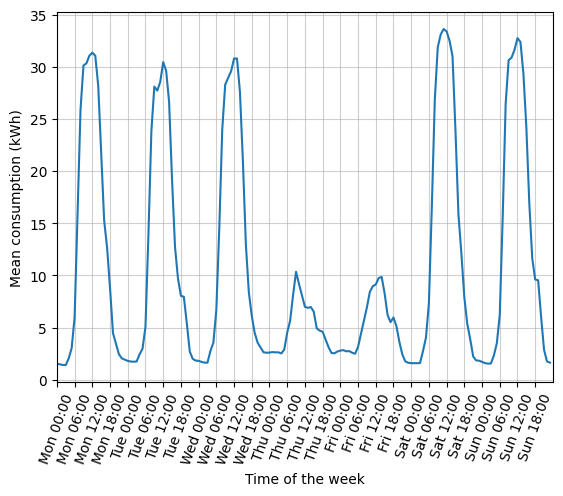

<Figure size 1000x600 with 0 Axes>

In [81]:
plt.show()
plt.plot(weekdays_hours, avg_hourly_consumption(caltech, "Consumption"))
plt.ylabel("Mean consumption (kWh)")
plt.xlabel("Time of the week")
plt.xticks(np.arange(0, 168, 6), rotation=70)
plt.grid(alpha=0.6)
ax = plt.gca()
ax.set_xlim([0, 168])
plt.figure(figsize=(10, 6))

Prints the hourly average from 0-23

In [82]:
# Combine "Dato" and "Time" into a datetime index
caltech["Datetime"] = pd.to_datetime(caltech["Dato"] + " " + caltech["Time"])
caltech.set_index("Datetime", inplace=True)  # noqa: PD002

# Group by hour and calculate the mean consumption
hourly_means_caltech = caltech.groupby(caltech.index.hour)["Consumption"].mean()

# Reset index to create a DataFrame with "Hour" and "Consumption"
# Convert the index to an integer and set name
hourly_means_caltech.index = hourly_means_caltech.index.astype(int)
hourly_means_caltech.index.name = "Hour"

hourly_means_caltech

C:\Users\mikke\AppData\Local\Temp\ipykernel_27468\2285478773.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  caltech["Datetime"] = pd.to_datetime(caltech["Dato"] + " " + caltech["Time"])


Hour
0      2.020184
1      1.977218
2      1.942306
3      1.893102
4      1.904960
5      2.487893
6      3.207024
7      5.567330
8     12.394626
9     20.131497
10    23.766955
11    24.093224
12    24.506954
13    24.989767
14    24.728112
15    22.811991
16    17.812118
17    12.150653
18     9.257396
19     7.291356
20     5.827426
21     4.151866
22     2.618916
23     2.081201
Name: Consumption, dtype: float64

Plots the daily pattern found by the hourly average

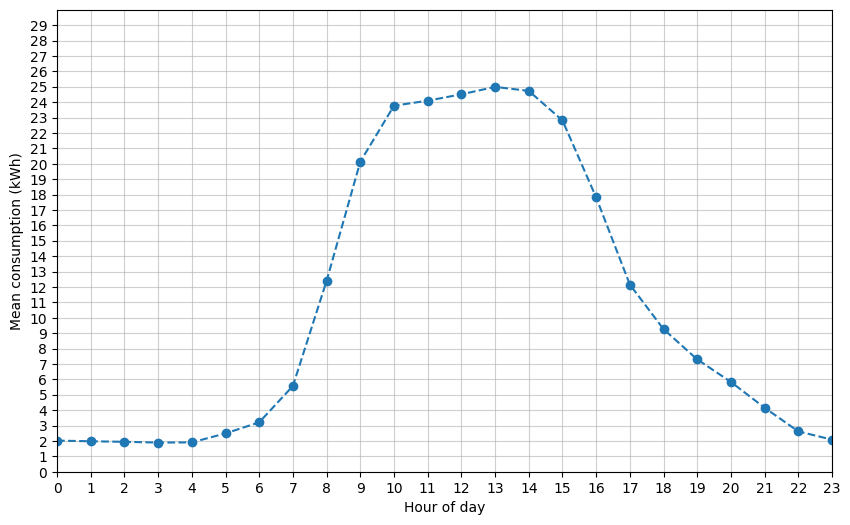

In [83]:
plt.figure(figsize=(10, 6))

plt.ylabel("Mean consumption (kWh)")
plt.xlabel("Hour of day")
plt.xticks(range(24))
plt.yticks(np.arange(0, 30, 1))
plt.grid(alpha=0.6)

ax = plt.gca()
ax.set_xlim([0, 23])
ax.set_ylim([0, 30])

plt.plot(hourly_means_caltech, "o--")

plt.show()